In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os
from create_analyze_runs_helpers import *

### Experiment settings

In [3]:
def small_setting():
    # SMALL setting experiments
    setting_name = 'small'
    common = {'image_side': 4, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 1, 'architecture': '20_10'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 1.0, 'epochs': 100, **common}],

        'frankwolfe':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'p': 2.0, 'R': 100.0, 'gamma': -1.0, 'ro': -1.0,
         'epochs': 100, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'p': 2.0, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 100, **common}],
    }
    return setting_name, common, param_groups

In [4]:
def medium_setting():
    # medium setting
    setting_name = 'medium_auto'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 3, 'architecture': '20_10'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 100, **common}
         for lr in [0.1, 0.01, 0.001, 0.0001]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 100, **common} for gamma in [-1.] + [0.1, 0.5, 1.]
         for ro in [-1.] + list(np.linspace(0, 1, 3))],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 500, **common} for gamma in [-1.] + [0.1, 0.3, 0.5]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 100, **common} for lr in [0.1, 0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [5]:
def big_setting():
    # BIG setting
    setting_name = 'big'
    common = {'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': lr, 'epochs': 1000, **common}
         for lr in [1., 0.5, 0.1, 0.05]],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': gamma, 'ro': ro,
         'epochs': 1000, **common} for gamma in [-1.] + [0.1, 0.5]
         for ro in [-1.] + [0.1, 0.3, 0.5]],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': gamma, 'ro': 1.0,
         'epochs': 5000, **common, 'repetitions': 10} for gamma in [-1.]],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': lr, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for lr in [0.01, 0.001, 0.0001]]
    }
    return setting_name, common, param_groups

In [6]:
def batch_size_setting():
    # Medium 2 setting (batch size effect)
    setting_name = 'medium2'
    common = {'image_side': 5, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 10, 'architecture': '20_10'}
    batches = [1000, 5000, 10000, 60000]
    param_groups = {
        'sgd':
        [{'optimizer': 'sgd', 'train_batch_size': bs, 'learning_rate': 1.0, 'epochs': 1000, **common}
         for bs in batches],

        'frankwolfe_stochastic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': bs, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0,
         'epochs': 1000, **common} for bs in batches],

        'frankwolfe_deterministic':
        [{'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0,
         'epochs': 10000, **common}],

        'adam':
        [{'optimizer': 'adam', 'train_batch_size': bs, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08,
         'epochs': 1000, **common} for bs in batches]
    }
    return setting_name, common, param_groups

### Choosing a setting

In [7]:
#R = small_setting()
#R = medium_setting()
R = big_setting()
#R = batch_size_setting()

In [8]:
# name of the setting, common parameters, parameter groups, all parameters
setting_name, common, param_groups = R
parameters = [x for group in param_groups.values() for x in group]

In [9]:
# group -> what changes
varying = {group: varying_for_optim(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'sgd': ['learning_rate'], 'frankwolfe_stochastic': ['ro', 'gamma'], 'frankwolfe_deterministic': [], 'adam': ['learning_rate']}


### Creating the `.sh` file

In [10]:
# writing the .sh file
write_sh_file(setting_name, parameters, common)

OUTPUT: ./output/run_big.sh
Total runs:  300
Total time (approx):  6.25


### Processing data

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


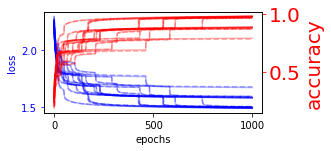

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.5309073066666665, 0.05571109502875786), 'test_loss': (1.5394290066666665, 0.055918187865219245), 'train_acc': (0.9322355626666666, 0.057928433446869425), 'test_acc': (0.9221466666666667, 0.058098776426205596), 'p_norm': (28.751473999999995, 0.8995616689593517), 'hessian_eigens_mean': (0.0008654594434447462, 0.000138091525703841), 'hessian_eigens_Max': (1.0254477066666667, 0.16259419932290414)}
-----


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


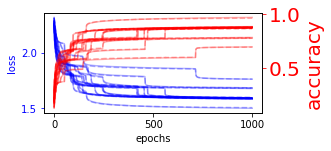

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.60403046, 0.058386484586404074), 'test_loss': (1.6075657733333335, 0.05703128560409005), 'train_acc': (0.8579188879999999, 0.060726416767634295), 'test_acc': (0.85292, 0.059245896623029225), 'p_norm': (25.334923066666665, 0.71838686907269), 'hessian_eigens_mean': (0.0007334522235774553, 9.170531405978788e-05), 'hessian_eigens_Max': (1.0584351386666666, 0.1887914686207568)}
-----


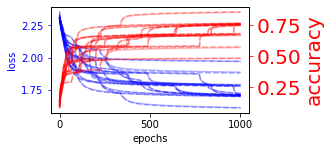

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.7455463066666668, 0.08403491502629502), 'test_loss': (1.7428780666666668, 0.0835628258903656), 'train_acc': (0.7179711126666668, 0.08802257500801018), 'test_acc': (0.7201866666666668, 0.08756534220543855), 'p_norm': (20.8920192, 0.4802016281687238), 'hessian_eigens_mean': (0.00048284303312662774, 8.830655430672787e-05), 'hessian_eigens_Max': (0.6628254446666666, 0.16385892586217057)}
-----


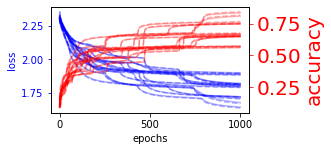

{'optimizer': 'sgd', 'train_batch_size': 1000, 'learning_rate': 0.05, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.7868286933333335, 0.0751180230389438), 'test_loss': (1.7836744533333333, 0.07664622524965697), 'train_acc': (0.6806455613333333, 0.08098890882594438), 'test_acc': (0.6836466666666666, 0.08308811280134415), 'p_norm': (20.073561599999998, 0.27948145046920925), 'hessian_eigens_mean': (0.00047753972247235654, 0.00010940909284525589), 'hessian_eigens_Max': (0.6555322259999999, 0.14228222061160556)}
-----


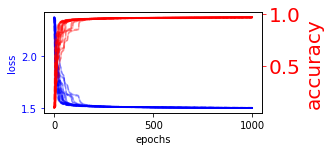

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.5020705666666667, 0.0011648834383271613), 'test_loss': (1.5039902, 0.001144998873361899), 'train_acc': (0.9685522199999999, 0.0011146637517924474), 'test_acc': (0.96428, 0.0013506541624955896), 'p_norm': (15.989523133333334, 0.12864800916965444), 'hessian_eigens_mean': (0.0012179113350454286, 8.858870077251204e-05), 'hessian_eigens_Max': (2.1557430200000005, 0.40466583315922156)}
-----


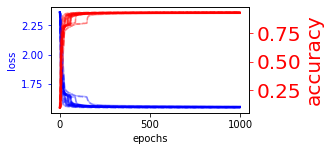

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.5561876466666669, 0.0027836500675352395), 'test_loss': (1.55207668, 0.0028733698931626135), 'train_acc': (0.9284611153333334, 0.002143094605234423), 'test_acc': (0.9316533333333332, 0.002467351256352086), 'p_norm': (11.906044366666666, 0.10393627033435225), 'hessian_eigens_mean': (0.0010941040464540054, 9.295576052555058e-05), 'hessian_eigens_Max': (1.8758799533333332, 0.23438452286537712)}
-----


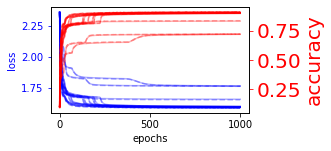

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.3, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.62036468, 0.05812176547358944), 'test_loss': (1.6152672133333332, 0.05943115412992152), 'train_acc': (0.8721377833333332, 0.06260834683423937), 'test_acc': (0.8764866666666667, 0.06364651199310838), 'p_norm': (10.425634533333332, 0.3546973301308909), 'hessian_eigens_mean': (0.0009825068575908095, 0.00010074659996050456), 'hessian_eigens_Max': (1.5975972266666671, 0.20126904834181358)}
-----


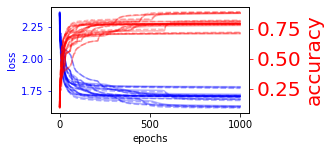

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': -1.0, 'ro': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.6962513866666669, 0.04490041427685447), 'test_loss': (1.6919320333333334, 0.04579252177589214), 'train_acc': (0.8007433386666667, 0.049102965828403594), 'test_acc': (0.8038666666666666, 0.05066244719272408), 'p_norm': (9.545016766666667, 0.30262856718199765), 'hessian_eigens_mean': (0.0009314221874814829, 0.00011966854547730232), 'hessian_eigens_Max': (1.3825612999999999, 0.2930361722882211)}
-----


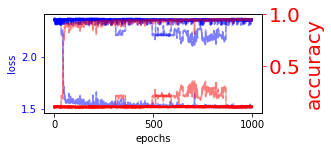

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (2.301544633333334, 0.21049958657903872), 'test_loss': (2.301058993333333, 0.21079892012758028), 'train_acc': (0.15981667053333337, 0.21128982142434227), 'test_acc': (0.16024, 0.21135535889428816), 'p_norm': (19.015304166666663, 1.7488954486495722), 'hessian_eigens_mean': (7.741942456510673e-06, 2.8967699455510407e-05), 'hessian_eigens_Max': (0.005692733124620734, 0.021300255110769304)}
-----


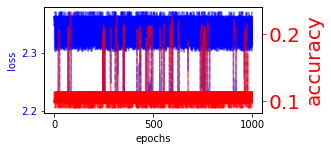

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (2.343974593333334, 0.02183855068290838), 'test_loss': (2.343632513333333, 0.022021849486570242), 'train_acc': (0.10218444586666668, 0.006681161887037093), 'test_acc': (0.10226666666666667, 0.0074936120944590024), 'p_norm': (13.037412033333334, 4.36558516400047), 'hessian_eigens_mean': (1.0367090687256813e-06, 1.723438002322999e-06), 'hessian_eigens_Max': (0.007228956047146559, 0.010809480936671145)}
-----


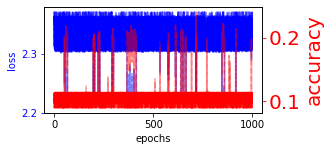

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.3, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (2.332690986666667, 0.02351104423717688), 'test_loss': (2.333100846666667, 0.023833462054119507), 'train_acc': (0.09953666793333335, 0.004143796650201817), 'test_acc': (0.09910666666666666, 0.004211961802084894), 'p_norm': (10.281210026666665, 5.623292085762519), 'hessian_eigens_mean': (6.82341225229609e-07, 1.5372252323634291e-06), 'hessian_eigens_Max': (0.0072218731758371775, 0.007401833213333302)}
-----


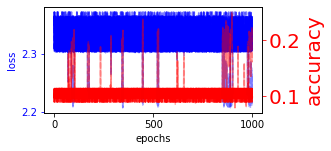

{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.1, 'ro': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (2.319933833333333, 0.025247832307683134), 'test_loss': (2.31997062, 0.024878606009185247), 'train_acc': (0.10423111093333333, 0.01668626040368155), 'test_acc': (0.10421333333333332, 0.01673443024293195), 'p_norm': (6.965786160000001, 3.480379036732501), 'hessian_eigens_mean': (9.015536793003221e-07, 4.373760298022002e-06), 'hessian_eigens_Max': (0.014587945270837939, 0.024557642819357378)}
-----
!!! File  is empty
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
None
-----
!!! File  is empty
{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.1,

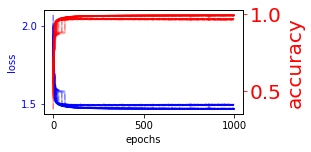

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.46804468, 0.0007346261545393899), 'test_loss': (1.4937126133333334, 0.0012594064077263527), 'train_acc': (0.9931788846666666, 0.0007075108338568946), 'test_acc': (0.9672333333333333, 0.001269470580815311), 'p_norm': (101.86554780000002, 2.2984718272962206), 'hessian_eigens_mean': (5.5474216903530704e-05, 3.083146220723474e-05), 'hessian_eigens_Max': (0.06618913347333334, 0.03143769574348475)}
-----


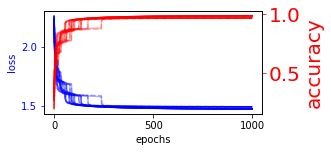

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.4735014, 0.00041844647606750936), 'test_loss': (1.4921729733333333, 0.0007092829350516834), 'train_acc': (0.9882600006666666, 0.0003874805822655945), 'test_acc': (0.9692533333333334, 0.000779629541655661), 'p_norm': (46.23854093333334, 0.5605531977119822), 'hessian_eigens_mean': (0.0006314866266472711, 7.626590840029563e-05), 'hessian_eigens_Max': (0.8475833093333336, 0.1728119906066448)}
-----


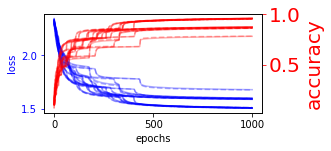

{'optimizer': 'adam', 'train_batch_size': 1000, 'learning_rate': 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}
{'train_loss': (1.5598807466666667, 0.05227984777448976), 'test_loss': (1.5617417333333337, 0.051480330467583026), 'train_acc': (0.9048866693333335, 0.05443375458567701), 'test_acc': (0.9017866666666665, 0.05364251879080831), 'p_norm': (24.633954999999993, 0.38729563348653157), 'hessian_eigens_mean': (0.0005259520452061528, 7.120606002225298e-05), 'hessian_eigens_Max': (0.6207355393333333, 0.11079194674081426)}
-----
Done: 15/20


In [11]:
# parameter id -> processed file
params_to_processed = []
missing = []
done = 0
for param in parameters:
    fs = process_file(get_file(**param), 'loss_decay_' + setting_name + '_' + shorten_dict(param, filename = True), True)
    print(param)
    print(dict_to_stat(fs))
    print("-----")
    if fs is not None:
        done += 1
    else:
        missing.append(param)
    params_to_processed.append(fs)
    #break
print('Done: %d/%d' % (done, len(parameters)))

In [12]:
# missing files
print(missing)

[{'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': -1.0, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.1, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.3, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 1000, 'R': 20.0, 'gamma': 0.5, 'ro': 0.5, 'epochs': 1000, 'image_side': 10, 'giveup': 100, 'accuracy_threshold': 0.0, 'p': 3.0, 'repetitions': 15, 'architecture': '50_50_20'}, {'optimizer': 'frankwolfe', 'train_batch_size': 60000, 'R': 20.0, 'gamma': -1.0, 'ro': 1.0, 'epochs': 

In [13]:
# all measured quantities
all_metrics = list(params_to_processed[0].keys())

# have 7 metrics
print(len(all_metrics))

7


=== OPT sgd / METRIC train_loss ===
=== OPT sgd / METRIC test_loss ===
=== OPT sgd / METRIC train_acc ===
=== OPT sgd / METRIC test_acc ===
=== OPT sgd / METRIC p_norm ===
=== OPT sgd / METRIC hessian_eigens_mean ===
=== OPT sgd / METRIC hessian_eigens_Max ===


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


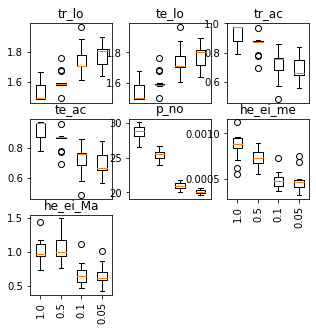

=== OPT frankwolfe_stochastic / METRIC train_loss ===
=== OPT frankwolfe_stochastic / METRIC test_loss ===
=== OPT frankwolfe_stochastic / METRIC train_acc ===
=== OPT frankwolfe_stochastic / METRIC test_acc ===
=== OPT frankwolfe_stochastic / METRIC p_norm ===
=== OPT frankwolfe_stochastic / METRIC hessian_eigens_mean ===
=== OPT frankwolfe_stochastic / METRIC hessian_eigens_Max ===


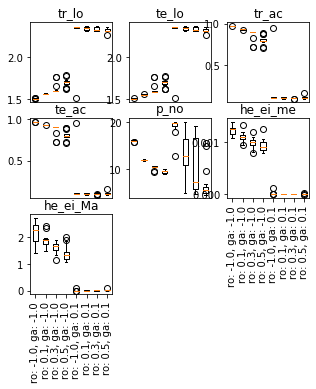

=== OPT frankwolfe_deterministic / METRIC train_loss ===
=== OPT frankwolfe_deterministic / METRIC test_loss ===
=== OPT frankwolfe_deterministic / METRIC train_acc ===
=== OPT frankwolfe_deterministic / METRIC test_acc ===
=== OPT frankwolfe_deterministic / METRIC p_norm ===
=== OPT frankwolfe_deterministic / METRIC hessian_eigens_mean ===
=== OPT frankwolfe_deterministic / METRIC hessian_eigens_Max ===


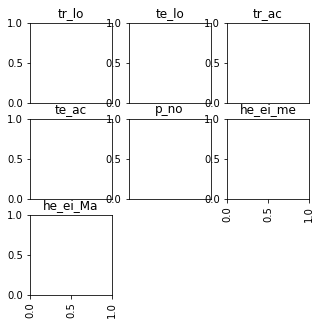

=== OPT adam / METRIC train_loss ===
=== OPT adam / METRIC test_loss ===
=== OPT adam / METRIC train_acc ===
=== OPT adam / METRIC test_acc ===
=== OPT adam / METRIC p_norm ===
=== OPT adam / METRIC hessian_eigens_mean ===
=== OPT adam / METRIC hessian_eigens_Max ===


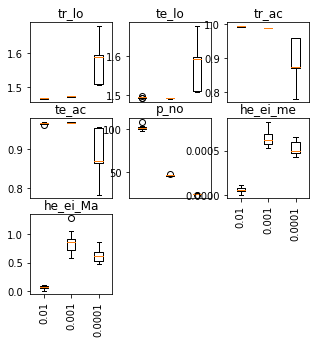

In [14]:
# printing all results (mean over runs/std)
for optim in param_groups.keys():
    data_for_metric = {}
    for m in all_metrics:
        print("=== OPT %s / METRIC %s ===" % (optim, m))
    
        # labels (parameters used)
        xs = []
        
        # values (arrays) for repetitions
        ys = []
    
        # going over parameters
        for p in param_groups[optim]:
            varying_params = dict_select(p, varying[optim])
            #print(varying_params)
            #print(dict_to_stat(param_to_result(p)))
            res = param_to_result(p, parameters, params_to_processed)
            if res is not None:
                ys.append(res[m])
                xs.append(shorten_dict(varying_params))
        data_for_metric[m] = (xs, ys)
        
    def plot_one(ax, i):
        """ Plot one box plot for metric i at axis ax """
        m = all_metrics[i] # current metric
        xs, ys = data_for_metric[m] # current data
        # plotting
        if xs:
            assert len(xs) == len(ys)
            ax.boxplot(ys, labels = xs)
    subplots(3, 3, all_metrics, plot_one, (5, 5))

### Batch size
Frank-Wolfe:batch size 1000-10K has almost no effect, a bit worse at 60K

Adam/SGD: Increase batch size -> decrease accuracy, increase loss. Hessian becomes a bit worse at 60K, but mostly decreases.

### Big

SGD: With decrease of learning rate, train/test accuracy decreases, loss increases, p-norm decreases and largest eigenvalues decrease. Choising LR=1

Frank-Wolfe Stochastic (g=-1). r = -1 gives best accuracy, constant rs are worse, the more the worse. p-norm decreases with accuracy, eigenvalues also decrease (max/mean). Constant gamma/rho give poor results

Frank-Wolfe deterministic: no data

Adam: with decrease of the learning rate, train accuracy decreases, sharp decrease for 0.0001. Hessian eigenvalues increase. Choosing LR = 0.001

In [15]:
# printing best parameters
for optim in param_groups.keys():
    idx = select_best(optim, parameters, param_groups, params_to_processed) # best hyperparameter idx
    p = parameters[idx] # best hyperparameters
    print(optim, dict_select(p, varying[optim]))

sgd {'learning_rate': 1.0}
frankwolfe_stochastic {'ro': -1.0, 'gamma': -1.0}
frankwolfe_deterministic {}
adam {'learning_rate': 0.001}


In [16]:
# final result for all optimizers (best)
data_for_optimizers = {}

# loop over metrics
for m in all_metrics:
    xs = [] # optimizers
    ys = [] # data for optimizers

    # print final results
    for optim in param_groups.keys():
        idx = select_best(optim, parameters, param_groups, params_to_processed) # best hyperparameter
        p = params_to_processed[idx]
        if p is not None:
            xs.append(shorten_name(optim))
            ys.append(p[m])
    
    # saving data...
    data_for_optimizers[m] = (xs, ys)

<Figure size 432x288 with 0 Axes>

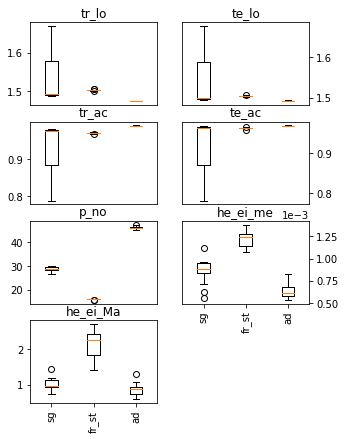

In [17]:
def plot_one(ax, i):
    """ Plot one box plot for metric i at axis ax """
    m = all_metrics[i] # current metric
    xs, ys = data_for_optimizers[m] # current data
    # plotting
    if xs:
        assert len(xs) == len(ys)
        ax.boxplot(ys, labels = xs)
    if i % 2 == 1:
        ax.yaxis.tick_right()
    if m == 'hessian_eigens_mean':
        #ax.yaxis.set_major_formatter(OOMFormatter(-4, "%1.1f"))
        ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
        pass
plt.subplots_adjust(wspace = 1)
subplots(4, 2, all_metrics, plot_one, (5, 7), 'best_' + setting_name)
plt.show()

### Batch size
Best accuracy: FW and Adam. Stochastic much better than deterministic for accuracy.

Hessian is a bit better for FW than for Adam

### Big

SGD: high variance, low Hessian

FW: high accuracy (a bit lower than Adam), low p-norm, high Hessian, hood generalization

Adam: highest accuracy, low variance, high p-norm, low Hessian, good generalization